In [1]:
from sideinfo_release import *
import matplotlib.pyplot as plt
import numpy as np
import timeit
import sys
import argparse

%matplotlib inline

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--data', type=str, default = '',  help='data path')
parser.add_argument('--dim', type=int, default = 1,  help='dimension of data')
parser.add_argument('--init', type=int, default = 5,  help='number of inits')
parser.add_argument('--out', type=str, default = 'test',  help='output_directory')
parser.add_argument('--prefix', type=str, default = 'http://localhost:8888/files',  help='url prefix')


opt = parser.parse_args(['--data', 'data/gtex.csv'])
print (opt)

Namespace(data='data/gtex.csv', dim=1, init=5, out='test', prefix='http://localhost:8888/files')


In [3]:
fn = opt.data
dim = opt.dim


data = np.loadtxt(open(fn, "rb"), delimiter=",", skiprows=1)
x = data[:,0:dim]
p = data[:,dim]
h = data[:,dim+1]
n_samples = len(x)

grids = None
x_prob = None



In [4]:
x = x[:100000]
p = p[:100000]
h = h[:100000]

with open('data_gtex_small.csv', 'w') as f:
    f.write('x_value, p_value, h\n')
    for i in range(len(x)):
        f.write("{}, {}, {}\n".format(x[i,0],p[i], h[i]))

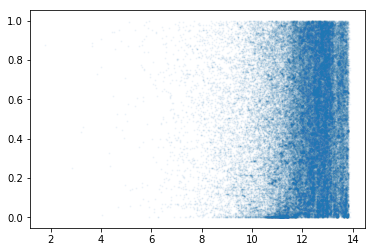

In [5]:
plt.scatter(x,p, 1, alpha = 0.05)

In [6]:
if dim == 1:
    max_x = np.max(x)
    min_x = np.min(x)
    x_prob = np.arange(min_x, max_x, (max_x - min_x)/1000.0)
    x_prob = x_prob.reshape((len(x_prob), 1))
    x_prob = Variable(torch.from_numpy(x_prob.astype(np.float32)))

if x_prob:
    x_prob = x_prob.cuda()

In [7]:
indices = np.random.permutation(x.shape[0])
A = [indices[:x.shape[0]/3], indices[x.shape[0]/3 : x.shape[0]/3*2], indices[x.shape[0]/3 * 2:]]
train = A
val = [A[1], A[2], A[0]]
test = [A[2], A[0], A[1]]
outputs = []
preds = []
gts = []

info = {}
info['filename'] = fn.replace('_', '\_')

loss_hists1 = []
loss_hists2 = []

efdr = np.zeros((3,3))
scales = np.zeros(3)

ninit = opt.init
if dim == 1:
    x = x.reshape((x.shape[0], 1))

In [18]:
i = 0
network = get_network(num_layers = 10, cuda = True, dim = dim)
optimizer = optim.Adagrad(network.parameters(), lr = 0.01)
train_idx = train[i]
val_idx = val[i]
test_idx = test[i]

#network init
try:
    p_target = opt_threshold_multi(x[train_idx,:], p[train_idx], 10)
except:
    p_target = np.ones(x[train_idx,:].shape[0]) * Storey_BH(p[train_idx])[1]


#plt.figure()
#plt.scatter(x, p_target)
loss_hist = train_network_to_target_p(network, optimizer, x[train_idx,:], p_target, num_it = 1000, cuda= True, dim = dim)
loss_hist2, s, s2 = train_network_adapt(network, optimizer, x[train_idx,:], p[train_idx], num_it = 3000, cuda = True, dim = dim, lambda2_ = 2e4, lambda_ = 2)



0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [19]:
#loss_hist2, s, s2 = train_network(network, optimizer, x[train_idx,:], p[train_idx], num_it = 3000, cuda = True, dim = dim, lambda2_ = 2e4, lambda_= 40)

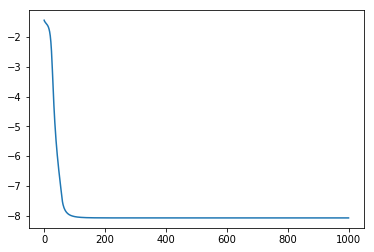

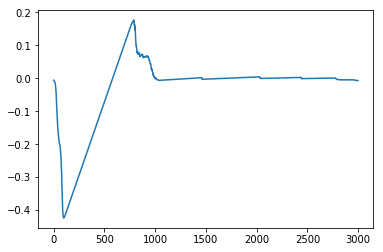

In [20]:
plt.figure()
plt.plot(np.log(loss_hist))
plt.figure()
plt.plot(loss_hist2)

In [21]:
threshold = network.forward(x_prob)

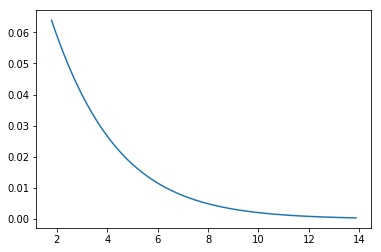

In [22]:
plt.plot(x_prob.cpu().data.numpy(), threshold.cpu().data.numpy())

In [23]:
n_samples = len(x[test_idx])
x_input = Variable(torch.from_numpy(x[test_idx,:].astype(np.float32).reshape(n_samples ,dim))).cuda()
p_input = Variable(torch.from_numpy(p[test_idx].astype(np.float32).reshape(n_samples ,1))).cuda()
output = network.forward(x_input) 
pred = (p_input < output).cpu().data.numpy()
pred = pred[:,0].astype(np.float32)

In [24]:
sum(pred)

241.0

In [25]:
BH(p)[0] /3

141

In [26]:
Storey_BH(p)

(429, 0.000223229, 0.95891666666666664)

In [28]:
s2/s

Variable containing:
1.00000e-02 *
  8.1989
[torch.cuda.FloatTensor of size 1 (GPU 0)]